# Introduction


In this homework, you'll be required to load in a dataset which has about 500 features. By using
Lasso ($L^1$) regression, we'll find the optimal constraint on the $L^1$ norm which gives us the best
$R^2$. Then we'll plot the results.

Recall we minimize the following on ** training data: $(x_i,y_i)$**

$$\min_{\beta} \frac{1}{N} \sum_{i=1}^N (y_i - \beta \cdot x_i)^2 + \lambda \|\beta \|_{L^1}.$$


Denoting $\beta_{\lambda}$ as the minimum of the above, we then choose $\lambda$ to maximize $R^2$ on **testing data: $(x_j,y_j)$**

$$ \max_{\lambda} 1 - \frac{\sum_{j} (y_j - \beta_{\lambda} \cdot x_j)^2}{\sum_j (y_j - \bar y)^2}$$


# Lasso Regularization

## Problem 1

a) Load in hw2data.csv from ../data into a pandas dataframe.

b) Set y to be the y variable in the dataframe from a and X to be the remaining features.

c) As shown in the Booking.com example, using Lasso regression, find the regularization strength
which optimizes the $R^2$. 

**Hint:** Take a range of alpha from `np.logspace(-8,-3,1000)`

d) Plot the training perforamnce versus the testing performance, and observe whree the test performance is
maximized. I've written an outline of the code you need.

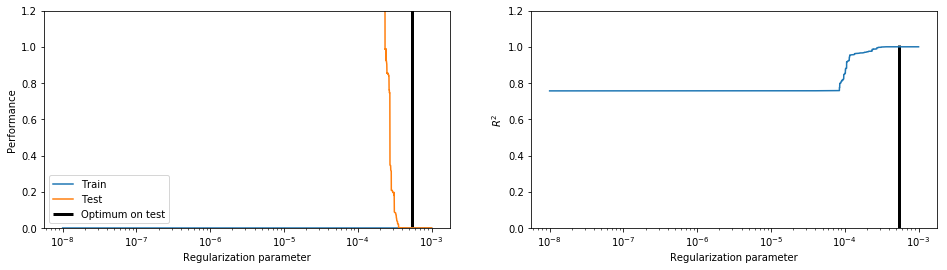

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

# Load data
csv = pd.read_csv("hw2data.csv")
y = csv["y"]
X = csv.iloc[:,0:-1]

# Split data
n_samples = X.shape[0]
X_train, y_train = X[:int(n_samples*0.8)], y[:int(n_samples*0.8)]  # 0.8*n_samples
X_test, y_test = X[int(n_samples*0.8):], y[int(n_samples*0.8):]    # 0.2*n_samples
# Fill these in
alphas = np.logspace(-8,-3,10000)
train_errors=[]
test_errors=[]
r2s = []

# start loop
for alpha in alphas:
    lasso = Lasso(max_iter=10000, alpha=alpha)
    model = lasso.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    train_error = np.mean((y_pred_train-y_train)**2)
    test_error = np.mean((y_pred_test-y_test)**2)
    r2 = r2_score(y_test, y_pred_test)
    train_errors.append(train_error)
    test_errors.append(test_error)
    r2s.append(r2)
train_erros = np.array(train_errors)
test_errors = np.array(test_errors)
r2s = np.array(r2s)

# find optima alpha
alpha_optim=alphas[np.argmax(r2s)]

# plot figure
plt.figure(1,figsize = (16,4))
# plot train and test errors
plt.subplot(1,2,1)
plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')
# plot r2 scores
plt.subplot(1,2,2)
plt.semilogx(alphas, r2s, label='Train')
plt.vlines(alpha_optim, 0, plt.ylim()[1], color='k',linewidth=3)
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('$R^2$')
plt.show()

e) Plot the top coefficients based on this optimal paramter. Why do you think so many are zero? 

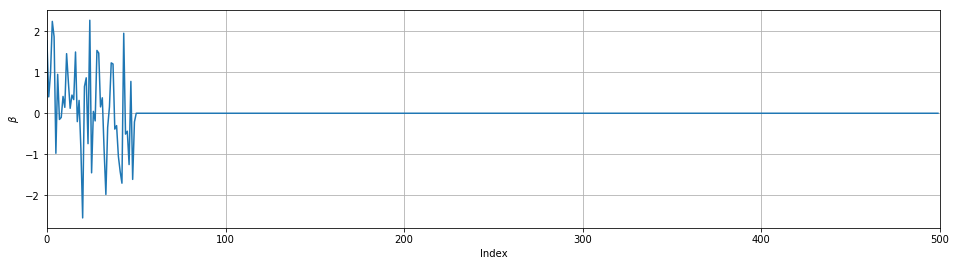

In [162]:
from sklearn.cross_validation import KFold
from sklearn import preprocessing
clf = Lasso(max_iter=10000, alpha=alpha_optim)
clf.fit(X,y)
coef = clf.coef_
plt.figure(1,figsize = (16,4))
plt.plot(coef)
plt.xlim([0, 500])
plt.xlabel('Index')
plt.ylabel('$\\beta$')
plt.grid()
plt.show()

Because the training data is only 180, but there are 500 features, so if  apha is small, there will be a overfitting phenomenon.We must standardScaler the data,let X obbey the standard normal distribution. 

f) Compute the $R^2$ with the optimal coefficient found above on 5 folds using cross_val_score and plot the
results. Does the model work well on all random subsets?

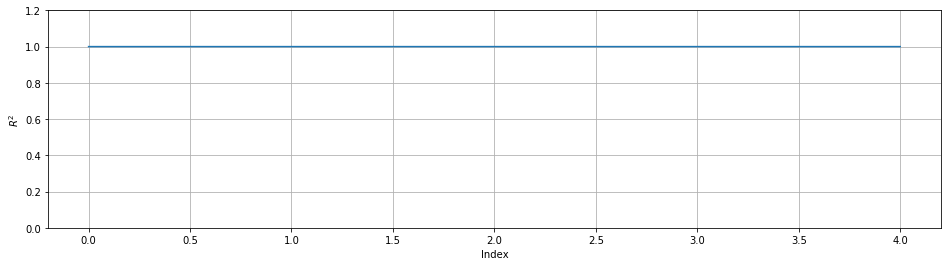

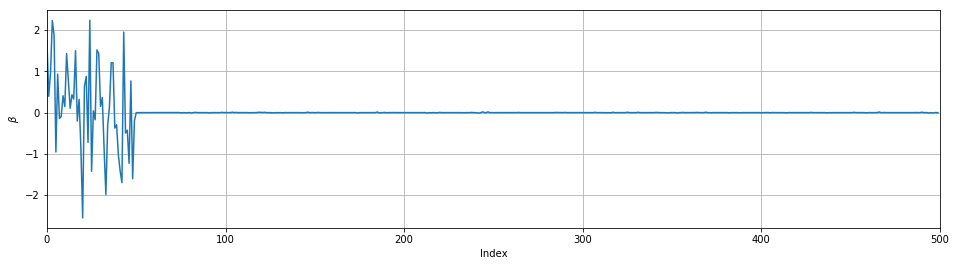

In [188]:
kf = KFold(len(y),n_folds=5,shuffle=True)
X_matrix = X.as_matrix().astype(np.float)
y_pred = y.copy()

coeffs=[]
r2s = []
for train_index, test_index in kf:
    X_train, X_test = X_matrix[train_index,:], X_matrix[test_index,:]
    y_train,y_test = y[train_index],y[test_index]
    # Initialize a classifier with key word arguments
    clf = Lasso(max_iter=10000, alpha=alpha_optim)
    clf.fit(X_train,y_train)
    y_pred_test = model.predict(X_test)
    r2 = r2_score(y_test, y_pred_test)
    coeffs.append(clf.coef_)
    r2s.append(r2)
    
coeffs_avgd = [(coeffs[0][i] + coeffs[1][i] + coeffs[2][i] + coeffs[3][i] + coeffs[4][i])/5 for i in range(0,len(X.columns))]
r2s_avgd = (r2s[0]+r2s[1]+r2s[2]+r2s[3]+r2s[4])/5

plt.figure(1,figsize = (16,4))
plt.plot(r2s)
plt.xlabel('Index')
plt.ylabel('$R^2$')
plt.ylim([0, 1.2])
plt.grid()
plt.show()

plt.figure(2,figsize = (16,4))
plt.plot(coeffs_avgd)
plt.xlim([0, 500])
plt.xlabel('Index')
plt.ylabel('$\\beta$')
plt.grid()
plt.show()

Clearly,many coefficients is still are zero,but from the $R^2$ figure, the model work well on all random subsets

f) Repeat e) but using cross validation. Use error bars on the features which are the standard deviation of the 
coefficiens obtained above. For this problem I"ll walk you through the code. You just need to apply your optimal
$\alpha$ found above. 

In [157]:
from sklearn.cross_validation import KFold
from sklearn import preprocessing
def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf:        
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
        coeffs.append(clf.coef_)
    return coeffs



scaler = preprocessing.StandardScaler()
X_scaled = X.as_matrix().astype(np.float)
X_scaled = scaler.fit_transform(X)

coeffs=run_cv_coeffs(X_scaled,np.array(y),Lasso,alpha=alpha_optim)

In [108]:
def get_coeffs(coeffs):
    coeffs_avgd = [(coeffs[0][i] + coeffs[1][i] + coeffs[2][i] + coeffs[3][i] + coeffs[4][i])/5 for i in range(0,len(X.columns))]
    coeffs_std = [np.std([coeffs[0][i],coeffs[1][i],coeffs[2][i],coeffs[3][i],coeffs[4][i]]) for i in range(0,len(X.columns))]
    return coeffs_avgd, coeffs_std
coeffs_avg,coeffs_std=get_coeffs(coeffs)

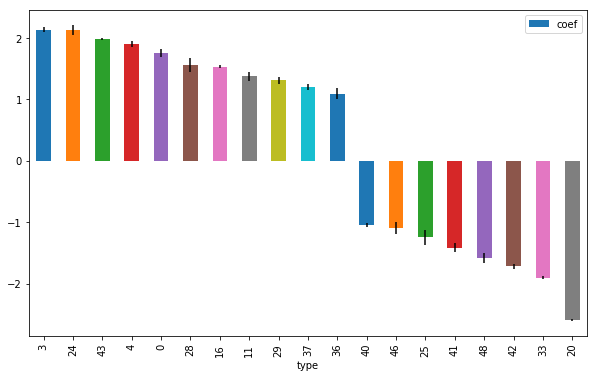

In [130]:
dfCoeffs = pd.DataFrame({'type':X.columns.values, 'coef':coeffs_avg, 'std':coeffs_std})
dfCoeffs = dfCoeffs[(dfCoeffs['coef']>1) |(dfCoeffs['coef']<-1) ]
dfCoeffs_sorted = dfCoeffs.sort_values(by='coef')[::-1];
yerr_vals = dfCoeffs_sorted['std'].values;
dfCoeffs_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_vals,figsize=(10,6))
plt.show()